# 🛫 Buscador de Rutas de Vuelo

¡Bienvenido! En este notebook, vamos a crear un programa que te permitirá buscar rutas de vuelo entre ciudades, considerando vuelos directos e indirectos.

## Funcionalidades:

1. **Buscar rutas entre ciudades**:
   - Ingresar ciudad de origen y destino.
   - Mostrar todas las rutas disponibles con vuelos directos e indirectos.

2. **Encontrar la ruta más rápida**:
   - Basada en el menor tiempo de vuelo total, incluyendo las conexiones.

3. **Encontrar la ruta más barata**:
   - Basada en el costo total del viaje, considerando posibles vuelos indirectos.

4. **Restricciones de tiempo entre conexiones**:
   - Configurar el tiempo mínimo de espera para las conexiones entre vuelos.

## Tecnologías a utilizar:
- Python
- Estructuras de datos como listas, diccionarios y grafos
- Algoritmos de búsqueda y optimización

¡Empecemos a buscar la mejor ruta para tu próximo viaje!

# 📚 Importar Librerías

Primero, importamos las librerías necesarias para manejar datos, crear grafos, visualizar gráficos y realizar búsquedas.


In [278]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import heapq
import numpy as np


# 2. Lectura del Archivo CSV 🗂️

📄 En esta parte, leemos el archivo CSV que contiene toda la información de los vuelos ✈️. Mostramos un resumen de los datos cargados para tener una idea de las opciones disponibles. ¡Comenzamos a planear el viaje! 🌍


In [279]:
def cargar_datos(archivo):
    datos = pd.read_csv(archivo)
    datos['Fecha_Salida'] = pd.to_datetime(datos['Fecha_Salida'] + ' ' + datos['Hora_Salida_Origen'])
    datos['Fecha_Llegada'] = pd.to_datetime(datos['Fecha_Llegada'] + ' ' + datos['Hora_Llegada_Destino'])
    datos['Duracion'] = datos['Fecha_Llegada'] - datos['Fecha_Salida']
    print("Datos de vuelos:")
    print(datos)
    return datos

# Cargar el archivo CSV
archivo = 'ejemplosvuelos.csv'  # Asegúrate de tener este archivo en tu directorio
datos = cargar_datos(archivo)

Datos de vuelos:
       ID   Origen     Destino        Fecha_Salida Hora_Salida_Origen  \
0   VU001   Madrid        CDMX 2024-09-24 08:15:00              08:15   
1   VU002  Toronto      Madrid 2024-09-19 13:02:00              13:02   
2   VU003   Sídney        CDMX 2024-09-18 06:45:00              06:45   
3   VU004     Roma       Tokio 2024-09-26 00:48:00              00:48   
4   VU005    París       Tokio 2024-09-25 10:06:00              10:06   
5   VU006  Londres       Tokio 2024-09-26 01:46:00              01:46   
6   VU007   Berlín      Madrid 2024-09-18 09:53:00              09:53   
7   VU008   Sídney  Nueva York 2024-09-23 02:02:00              02:02   
8   VU009   Madrid        Roma 2024-09-09 14:40:00              14:40   
9   VU010    Tokio      Madrid 2024-09-20 20:10:00              20:10   
10  VU011   Berlín       Tokio 2024-09-30 20:44:00              20:44   
11  VU012     CDMX       Tokio 2024-09-27 01:51:00              01:51   
12  VU013   Sídney     Londres 202

# 3. Creación del Grafo de Vuelos 🌐

🛫 En esta sección, generamos el **grafo dirigido** con las rutas de vuelos conectando las ciudades. Cada vuelo representa una conexión entre ciudades, formando un gran mapa de posibilidades 🌍✨.


In [280]:
def construir_grafo(datos):
    grafo = nx.MultiDiGraph()
    for idx, fila in datos.iterrows():
        origen = fila['Origen']
        destino = fila['Destino']
        tiempo = fila['Duracion'].total_seconds() / 3600
        costo = fila['Precio_Vuelo']
        fecha_salida = fila['Fecha_Salida']
        fecha_llegada = fila['Fecha_Llegada']
        grafo.add_edge(origen, destino, tiempo=tiempo, costo=costo, fecha_salida=fecha_salida, fecha_llegada=fecha_llegada)
    return grafo

grafo = construir_grafo(datos)

# ✈️ Visualización del Grafo de Vuelos

En este apartado, visualizaremos un grafo que representa las rutas de vuelo disponibles. Cada arista del grafo tiene un peso que puede representar el **tiempo** o el **costo** del vuelo entre dos ciudades. Además, el grosor y color de las aristas varían según el peso.

## 🚀 Función: `visualizar_grafo_mejorado`

Esta función crea una visualización del grafo con el peso de las aristas (tiempo o costo) y añade una barra de colores para interpretar los valores. Los colores más oscuros representan los valores más bajos.

### Código:


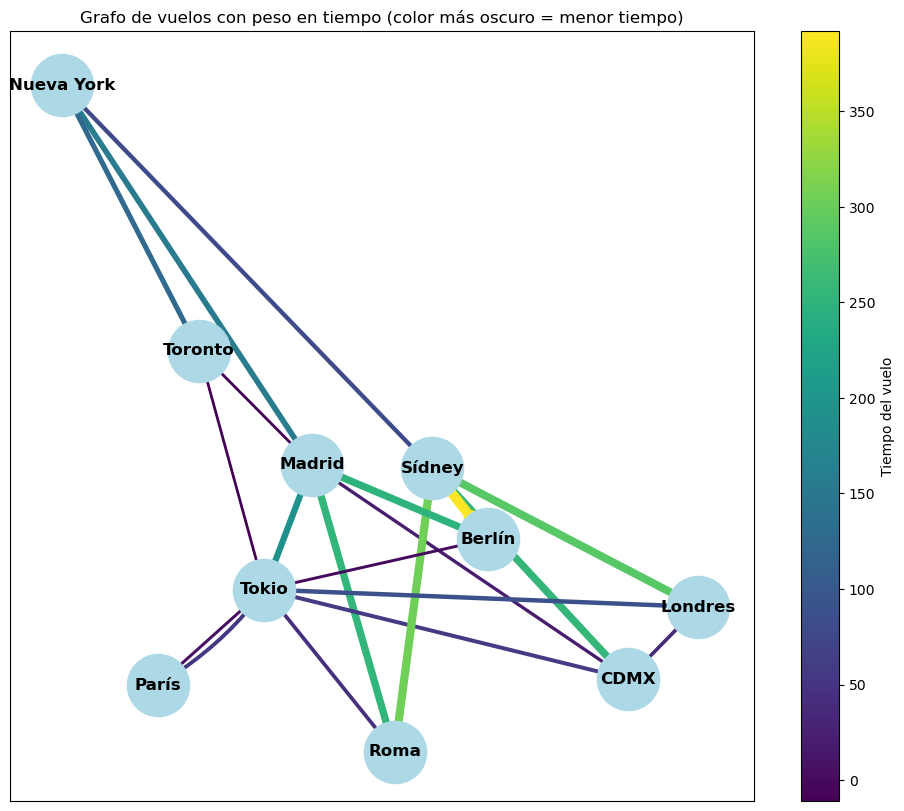

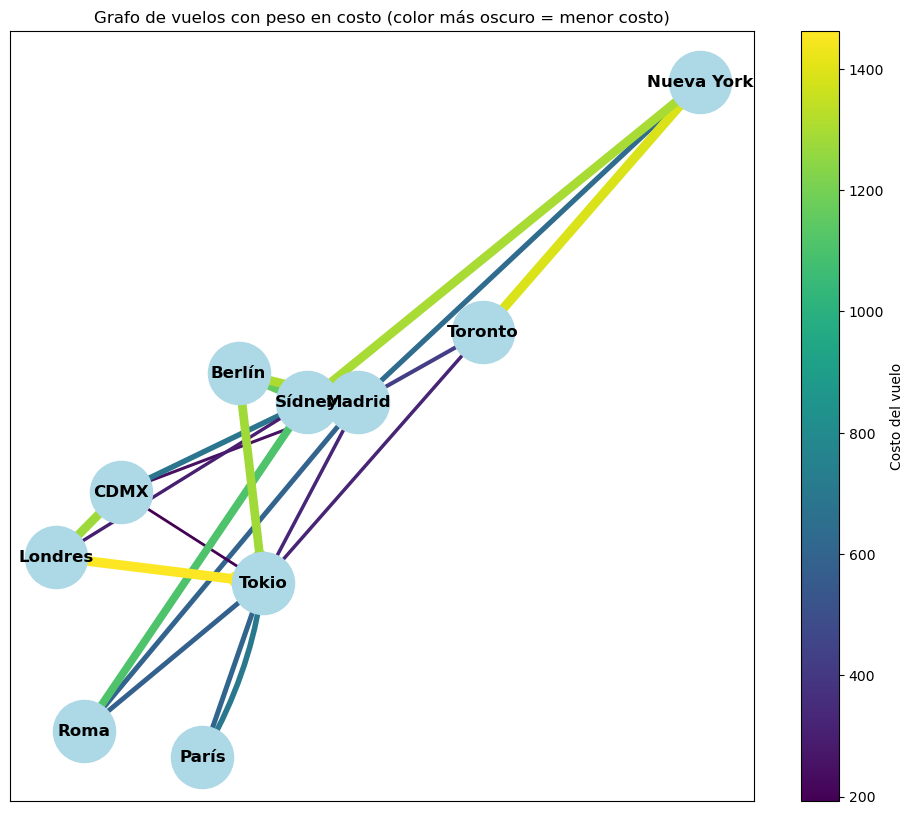

In [281]:
def visualizar_grafo_mejorado(grafo, peso='tiempo'):
    posiciones = nx.spring_layout(grafo)
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Dibujar los nodos
    nx.draw_networkx_nodes(grafo, posiciones, node_color='lightblue', node_size=2000, ax=ax)
    nx.draw_networkx_labels(grafo, posiciones, font_size=12, font_weight='bold', ax=ax)
    
    # Recopilar los pesos de las aristas para normalizar
    valores_peso = [data[peso] for u, v, key, data in grafo.edges(keys=True, data=True)]
    min_peso, max_peso = min(valores_peso), max(valores_peso)
    
    norm_pesos = [(p - min_peso) / (max_peso - min_peso) if max_peso - min_peso != 0 else 0.5 for p in valores_peso]
    
    # Dibujar las aristas
    for idx, (u, v, key, data) in enumerate(grafo.edges(keys=True, data=True)):
        color = plt.cm.viridis(norm_pesos[idx])
        width = 2 + 5 * norm_pesos[idx]
        nx.draw_networkx_edges(grafo, posiciones, edgelist=[(u, v)], width=width, edge_color=[color], connectionstyle=f'arc3,rad={0.1 * key}', ax=ax, arrows=True)
    
    # Añadir barra de color
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min_peso, vmax=max_peso))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label=f'{peso.capitalize()} del vuelo')
    plt.title(f"Grafo de vuelos con peso en {peso} (color más oscuro = menor {peso})")
    plt.show()

# Visualizar el grafo con peso en tiempo y en costo
visualizar_grafo_mejorado(grafo, peso='tiempo')
visualizar_grafo_mejorado(grafo, peso='costo')


# 🗺️ Construir Diccionario de Vuelos
Construimos un diccionario que agrupa los vuelos por su ciudad de origen, para facilitar la búsqueda de conexiones.

In [282]:
def construir_diccionario_vuelos(datos):
    vuelos_por_origen = {}
    for idx, fila in datos.iterrows():
        origen = fila['Origen']
        if origen not in vuelos_por_origen:
            vuelos_por_origen[origen] = []
        vuelo_info = {
            'Origen': origen,
            'Destino': fila['Destino'],
            'Fecha_Salida': fila['Fecha_Salida'],
            'Fecha_Llegada': fila['Fecha_Llegada'],
            'Precio_Vuelo': fila['Precio_Vuelo'],
            'Duracion': fila['Duracion']
        }
        vuelos_por_origen[origen].append(vuelo_info)
    return vuelos_por_origen

vuelos_por_origen = construir_diccionario_vuelos(datos)

# 🚀 Función: Ruta más rápida

La función `ruta_mas_rapida` encuentra la ruta de vuelo más rápida entre dos ciudades, usando un algoritmo basado en una cola de prioridad (heap). Se busca minimizar el tiempo total de viaje considerando las escalas y las horas de vuelo.

## 📌 Descripción:

1. **Cola de Prioridad**: Se utiliza una estructura de tipo heap (cola de prioridad) para almacenar las rutas, priorizando aquellas con menor tiempo total.
2. **Visitados**: Un conjunto para asegurarse de que no se visiten los mismos aeropuertos en las mismas condiciones varias veces.
3. **Recorrido**: Se recorren los vuelos posibles desde la ciudad de origen hasta el destino final, sumando los tiempos de vuelo y respetando las restricciones de espera entre conexiones (al menos una hora).
4. **Salida**: Al encontrar la ruta más rápida, se imprime la secuencia de vuelos y el tiempo total del viaje.


In [283]:
def ruta_mas_rapida(inicio, destino):
    cola = []
    visitados = set()
    for vuelo in vuelos_por_origen.get(inicio, []):
        duracion_total = vuelo['Duracion'].total_seconds() / 3600
        ruta = [vuelo]
        heapq.heappush(cola, (duracion_total, vuelo['Fecha_Llegada'], ruta))
    
    while cola:
        duracion_actual, llegada_actual, ruta_actual = heapq.heappop(cola)
        ultimo_vuelo = ruta_actual[-1]
        aeropuerto_actual = ultimo_vuelo['Destino']
        
        if aeropuerto_actual == destino:
            print(f"🛬 Ruta más rápida de {inicio} a {destino}:")
            for vuelo in ruta_actual:
                print(f"- Vuelo de {vuelo['Origen']} a {vuelo['Destino']} ({vuelo['Duracion']})")
            print(f"⏳ Tiempo total: {duracion_actual:.2f} horas.")
            return
        
        if (aeropuerto_actual, llegada_actual) not in visitados:
            visitados.add((aeropuerto_actual, llegada_actual))
            for vuelo in vuelos_por_origen.get(aeropuerto_actual, []):
                if vuelo['Fecha_Salida'] >= llegada_actual + pd.Timedelta(hours=1):
                    nueva_duracion = duracion_actual + vuelo['Duracion'].total_seconds() / 3600
                    nueva_ruta = ruta_actual + [vuelo]
                    heapq.heappush(cola, (nueva_duracion, vuelo['Fecha_Llegada'], nueva_ruta))
    
    print(f"❌ No se encontró una ruta de {inicio} a {destino}.")

# 💰 Función: Ruta más barata

La función `ruta_mas_barata` encuentra la ruta de vuelo más económica entre dos ciudades, utilizando un algoritmo basado en una cola de prioridad (heap) que prioriza el costo total del viaje.

## 📌 Descripción:

1. **Cola de Prioridad**: Se utiliza una estructura de tipo heap para priorizar las rutas con menor costo total.
2. **Visitados**: Un conjunto que asegura que no se visiten los mismos aeropuertos bajo las mismas condiciones varias veces.
3. **Recorrido**: Se evalúan todas las posibles rutas desde la ciudad de origen hasta el destino final, sumando los costos de vuelo y respetando las restricciones de tiempo entre conexiones (al menos una hora).
4. **Salida**: Al encontrar la ruta más económica, se imprime la secuencia de vuelos y el costo total del viaje.


In [284]:
def ruta_mas_barata(inicio, destino):
    cola = []
    visitados = set()
    for vuelo in vuelos_por_origen.get(inicio, []):
        costo_total = vuelo['Precio_Vuelo']
        ruta = [vuelo]
        heapq.heappush(cola, (costo_total, vuelo['Fecha_Llegada'], ruta))
    
    while cola:
        costo_actual, llegada_actual, ruta_actual = heapq.heappop(cola)
        ultimo_vuelo = ruta_actual[-1]
        aeropuerto_actual = ultimo_vuelo['Destino']
        
        if aeropuerto_actual == destino:
            print(f"🛬 Ruta más barata de {inicio} a {destino}:")
            for vuelo in ruta_actual:
                print(f"- Vuelo de {vuelo['Origen']} a {vuelo['Destino']} (${vuelo['Precio_Vuelo']:.2f})")
            print(f"💰 Costo total: ${costo_actual:.2f}.")
            return
        
        if (aeropuerto_actual, llegada_actual) not in visitados:
            visitados.add((aeropuerto_actual, llegada_actual))
            for vuelo in vuelos_por_origen.get(aeropuerto_actual, []):
                if vuelo['Fecha_Salida'] >= llegada_actual + pd.Timedelta(hours=1):
                    nuevo_costo = costo_actual + vuelo['Precio_Vuelo']
                    nueva_ruta = ruta_actual + [vuelo]
                    heapq.heappush(cola, (nuevo_costo, vuelo['Fecha_Llegada'], nueva_ruta))
    
    print(f"❌ No se encontró una ruta de {inicio} a {destino}.")

# 🔍 Función: Búsqueda en Anchura (BFS)

La función `busqueda_bfs` encuentra todas las rutas posibles entre dos ciudades utilizando un algoritmo de búsqueda en anchura (BFS), que explora todas las rutas de manera sistemática antes de profundizar en una sola.

## 📌 Descripción:

1. **Cola (Queue)**: Utiliza una cola para almacenar las rutas en proceso de evaluación. Comienza evaluando los vuelos desde la ciudad de origen.
2. **Visitados**: Un conjunto que asegura que no se visiten las mismas combinaciones de aeropuertos y tiempos de llegada varias veces.
3. **Recorrido**: Evalúa todas las posibles rutas desde la ciudad de origen hasta el destino final, asegurándose de que cada vuelo salga al menos una hora después de la llegada del vuelo anterior.
4. **Salida**: Al encontrar una ruta completa hacia el destino, se añade a la lista de rutas encontradas.


In [285]:
# Función para buscar rutas con BFS
def busqueda_bfs(inicio, destino):
    visitados = set()
    cola = deque()
    rutas_encontradas = []
    
    # Comenzamos con los vuelos que salen de la ciudad de inicio
    for vuelo in vuelos_por_origen.get(inicio, []):
        cola.append(([vuelo], vuelo['Fecha_Llegada']))
    
    # Búsqueda en anchura
    while cola:
        ruta_actual, llegada_actual = cola.popleft()  # Tomamos la primera ruta en la cola
        ultimo_vuelo = ruta_actual[-1]
        aeropuerto_actual = ultimo_vuelo['Destino']
        
        # Si llegamos al destino, agregamos la ruta encontrada
        if aeropuerto_actual == destino:
            rutas_encontradas.append(ruta_actual)
            continue
        
        # Si el aeropuerto actual no ha sido visitado
        if (aeropuerto_actual, llegada_actual) not in visitados:
            visitados.add((aeropuerto_actual, llegada_actual))
            
            # Buscamos vuelos desde el aeropuerto actual, respetando las horas de salida
            for vuelo in vuelos_por_origen.get(aeropuerto_actual, []):
                if vuelo['Fecha_Salida'] >= llegada_actual + pd.Timedelta(hours=1):
                    nueva_ruta = ruta_actual + [vuelo]
                    cola.append((nueva_ruta, vuelo['Fecha_Llegada']))
    
    return rutas_encontradas if rutas_encontradas else None
# Función para mostrar las rutas encontradas con BFS
def mostrar_rutas_bfs(inicio, destino):
    rutas = busqueda_bfs(inicio, destino)
    if rutas:
        print(f"🌐 Rutas encontradas entre {inicio} y {destino} (BFS):")
        for idx, ruta in enumerate(rutas, 1):
            print(f"{idx})")
            for vuelo in ruta:
                print(f"   - Vuelo de {vuelo['Origen']} a {vuelo['Destino']} saliendo el {vuelo['Fecha_Salida']}")
    else:
        print(f"❌ No se encontraron rutas entre {inicio} y {destino}.")

# 🔍 Función: Búsqueda en Profundidad (DFS)

La función `busqueda_dfs` encuentra todas las rutas posibles entre dos ciudades utilizando un algoritmo de búsqueda en profundidad (DFS). A diferencia de BFS, este algoritmo explora una ruta completa antes de retroceder y probar otras.

## 📌 Descripción:

1. **Recursividad**: Utiliza la recursión para profundizar en una ruta hasta que llegue al destino o no haya más vuelos disponibles.
2. **Visitados**: Utiliza un conjunto para evitar visitar las mismas combinaciones de aeropuerto y tiempo de llegada varias veces.
3. **Condiciones**: Evalúa los vuelos que salen al menos una hora después de la llegada del vuelo anterior.
4. **Salida**: Al encontrar una ruta completa hacia el destino, la ruta se guarda en la lista de rutas encontradas.


In [286]:
def busqueda_dfs(inicio, destino, llegada_anterior=None, ruta_actual=None, rutas_encontradas=None, visitados=None):
    if ruta_actual is None:
        ruta_actual = []
    if rutas_encontradas is None:
        rutas_encontradas = []
    if visitados is None:
        visitados = set()
    
    # Si es la primera llamada, iniciamos con los vuelos desde la ciudad de inicio
    if llegada_anterior is None:
        for vuelo in vuelos_por_origen.get(inicio, []):
            busqueda_dfs(vuelo['Destino'], destino, vuelo['Fecha_Llegada'], [vuelo], rutas_encontradas, {(inicio, vuelo['Fecha_Llegada'])})
    else:
        # Si no hemos visitado el aeropuerto actual
        if (inicio, llegada_anterior) not in visitados:
            visitados.add((inicio, llegada_anterior))
            
            # Si llegamos al destino, agregamos la ruta encontrada
            if inicio == destino:
                rutas_encontradas.append(ruta_actual.copy())
                return
            
            # Buscamos vuelos que salgan después de la llegada más una hora
            for vuelo in vuelos_por_origen.get(inicio, []):
                if vuelo['Fecha_Salida'] >= llegada_anterior + pd.Timedelta(hours=1):
                    ruta_actual.append(vuelo)
                    busqueda_dfs(vuelo['Destino'], destino, vuelo['Fecha_Llegada'], ruta_actual, rutas_encontradas, visitados)
                    ruta_actual.pop()
    
    return rutas_encontradas if rutas_encontradas else None


# Función para mostrar las rutas encontradas con DFS
def mostrar_rutas_dfs(inicio, destino):
    rutas = busqueda_dfs(inicio, destino)
    if rutas:
        print(f"🌐 Rutas encontradas entre {inicio} y {destino} (DFS):")
        for idx, ruta in enumerate(rutas, 1):
            print(f"{idx})")
            for vuelo in ruta:
                print(f"   - Vuelo de {vuelo['Origen']} a {vuelo['Destino']} saliendo el {vuelo['Fecha_Salida']}")
    else:
        print(f"❌ No se encontraron rutas entre {inicio} y {destino}.")

# 🗺️ Destinos Directos desde una Ciudad
Podemos obtener una lista de destinos a los que podemos volar directamente desde una ciudad específica.

In [287]:
def destinos_directos(origen):
    if origen in vuelos_por_origen:
        destinos = [vuelo['Destino'] for vuelo in vuelos_por_origen[origen]]
        destinos_unicos = list(set(destinos))
        return destinos_unicos if destinos_unicos else None
    else:
        return None

# 🌐 Destinos Indirectos desde una Ciudad
Podemos obtener una lista de destinos a los que podemos volar indirectamente desde una ciudad específica.

In [288]:
def destinos_indirectos(inicio):
    visitados = set()
    cola = deque([inicio])
    destinos = []

    while cola:
        aeropuerto_actual = cola.popleft()
        if aeropuerto_actual not in visitados:
            visitados.add(aeropuerto_actual)
            if aeropuerto_actual != inicio:
                destinos.append(aeropuerto_actual)
            for vuelo in vuelos_por_origen.get(aeropuerto_actual, []):
                if vuelo['Destino'] not in visitados:
                    cola.append(vuelo['Destino'])
    return destinos if destinos else None

# 👥 Interacción con el Usuario
Solicitamos al usuario que introduzca las ciudades de origen y destino, y luego mostramos la ruta más rápida, la más barata y todas las rutas posibles.

In [289]:
# Solicitar la ciudad de origen y destino al usuario
origen_usuario = input("✈️ Introduce la ciudad de origen: ")
destino_usuario = input("🛬 Introduce la ciudad de destino: ")

# Mostrar la ruta más rápida
ruta_mas_rapida(origen_usuario, destino_usuario)
print("\n")

# Mostrar la ruta más barata
ruta_mas_barata(origen_usuario, destino_usuario)
print("\n")

# Mostrar todas las rutas encontradas por BFS
mostrar_rutas_bfs(origen_usuario, destino_usuario)
print("\n")

# Mostrar todas las rutas encontradas por DFS
mostrar_rutas_dfs(origen_usuario, destino_usuario)
print("\n")

# Mostrar destinos directos
destinos = destinos_directos(origen_usuario)
if destinos:
    print(f"🛫 Desde {origen_usuario} puedes volar directamente a: {', '.join(destinos)}")
else:
    print(f"❌ No hay vuelos directos desde {origen_usuario}.")

# Mostrar destinos indirectos
destinos_indirectos = destinos_indirectos(origen_usuario)
if destinos_indirectos:
    print(f"🛫 Desde {origen_usuario} puedes volar a: {', '.join(destinos_indirectos)}")
else:
    print(f"❌ No hay rutas indirectas desde {origen_usuario}.")


🌍 Buscando las mejores rutas de Tokio a Toronto. ¡Espera un momento! 🚀

🔝-------------------------------🔝
🚀 Ruta más rápida de Tokio a Toronto:
❌ No se encontró una ruta de Tokio a Toronto.
🔝-------------------------------🔝

💰-------------------------------💰
💸 Ruta más barata de Tokio a Toronto:
❌ No se encontró una ruta de Tokio a Toronto.
💰-------------------------------💰

❌ No se encontraron rutas entre Tokio y Toronto.


❌ No se encontraron rutas entre Tokio y Toronto.




# 📌 Comentarios Finales
Este programa te permite explorar rutas de vuelo entre diferentes ciudades, teniendo en cuenta restricciones de tiempo y conexiones. Puedes modificar el archivo CSV para agregar más vuelos y probar diferentes escenarios. 🛩️

